# Development of Quarterly QA on Siemens Scanners

This will be performed on the Siemens 'long bottle' phantom in the most used head coil. This is the phantom used for the Siemens coil QA and it can be easily positioned using the dedicated Siemens foam pad.

We'll need to check that this phantom is available on all the scanners. If not then we may need to drop back to using the short bottle and its holder. We should be able to code round the variation - the short bottle has a slightly larger diameter so we can identify the phantom from this.

We'll acquire the following images:
 - SE, 2 acqusitions, with/without PSN, multiple elements, RMS coil combine -> SNR, Unif, XY gradient scale
 - SE, 2 acquisitions, without PSN, multiple elements, RMS coil combine, TX switched off by setting voltages to zero
 - TSE, 1 acquisition, ghosting -> short term stability
 - EPI, 60+ acquisitions, ghosting and long term stability, eddy currents and shim (distortion)

Other possible acquisitions to consider:
 - SE, multiple flip angles
 - CPMG service shim sequence
 - Siemens flip angle mapper
 - SE-EPI diffn for eddy currents -> measure variability in circularity (as encoding directions change)
 
Measurements to be made:
 - SNR, over 50% and (say) 80% of phantom
 - Non-circularity of edge of phantom
 - NMEA uniformity measure using smoothing kernel eg `[[1,2,1,],[2,4,2],[1,2,1]]` - 'normalised absolute deviation'
 - Ghosting on SE/TSE/EPI

### Boiler plate

In [1]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

from mriqa.phantoms import phantom_mask_2d, find_phantom, SIEMENSLONGBOTTLE
from mriqa.dcmio import (
    fetch_series, rx_coil_name, approx_slice_orientation,
    approx_phase_orientation, series_number, seq_name, protocol_name,
    pix_spacing_yx
)
from mriqa.reports import snr_report, ghosting_report, uniformity_report
from mriqa.tools import mean_im, diff_im, snr_im, snr
from dcmextras.siemenscsa import csa, phoenix
import pandas as pd
import warnings

### Series Index
Details of series to analyse.

In [2]:
patid = 'PQACRK20161215'
studyid = '1'
series = {
    'Signal': [26, 30],
    'Signal_Combined': [27, 31],
    'Noise': [22, 24],
    'Noise_Combined': [23, 25],
    'Geometry': [28, 32]
}

### Ghosting
We can use the same routines for ghosting as for the small GE sphere. As the phantom is cylindrical, of course, only the axial plane will be considered.

Note that the actual values obtained for the ghosting ratio will vary somewhat according to exactly where the ghosting regions of interest are defined. In particular, any ringing-like behaviour will only be detected with a ROI close to the phantom. Nyquist ghosting on the other hand is best detected with an ROI that comprises the phantom shifted by N/2 in the *phase encoding* direction.

As the test compares background signal in the phase encoding and the readout direction we are only sensitive to these seprately (generally in the phase encoding direction). Any thing that is manifest on both axes wuill cancel out in the subtraction. Possibly a better comparison would be with the image corners.

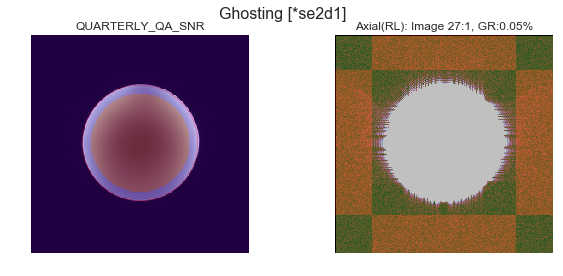

Series                        27
Frames                         1
TR                           500
TE                            20
Matrix                (256, 256)
Sequence                  *se2d1
FoV               (250.0, 250.0)
Bandwidth                    260
PhaseAxis                    ROW
PhaseDirection                RL
Protocol        QUARTERLY_QA_SNR
Orientation                Axial
Phantom                  1428.82
Left                     28.0506
Right                    28.9234
Top                      27.5154
Bottom                   28.0771
GhostRatio             0.0483454

In [60]:
# LONGBOTTLE: Ghosting
raw_tra = fetch_series(patid, studyid, sernos=series['Signal_Combined'])
results = ghosting_report([raw_tra[0]], phantom=SIEMENSLONGBOTTLE)
results.T